In [43]:
import yaml
import os
import sys
# sys.path.append('../../')
import numpy as np
import pandas as pd
from collections import Counter
from omegaconf import OmegaConf
# import torchmetrics
# import torch
# from torch import nn
from sklearn.model_selection import KFold, StratifiedKFold
from selene_sdk.utils import load_path, parse_configs_and_run
from selene_sdk.utils.config_utils import module_from_dir, module_from_file
from selene_sdk.utils.config import instantiate
from src.dataset import EncodeDataset, LargeRandomSampler, encode_worker_init_fn, subset_encode_worker_init_fn
from src.transforms import *
from src.utils import interval_from_line, get_skf_datasets
# from torchvision import transforms
# from torchmetrics import BinnedAveragePrecision, AveragePrecision, Accuracy
from tqdm import tqdm
import json

import copy
from src.utils import expand_dims
import gc
gc.enable()

from src.metrics import jaccard_score, threshold_wrapper
from sklearn.metrics import average_precision_score
from selene_sdk.utils.performance_metrics import compute_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
path = 'model_configs/biox_dnase_multi_ct_crossval.yaml'
configs = load_path(path, instantiate=False)
configs['dataset']["loader_args"]["batch_size"]

256

In [33]:
all_idx = np.load('results/all_idx.npy')
all_idx.shape

(11576175,)

In [32]:
all_targets_mean = np.load('results/all_targets_mean.npy')
all_targets_mean.shape

(11576175,)

In [48]:
y_cat = pd.cut(all_targets_mean, 10, labels=range(10))
y_cat = np.array(y_cat)

In [53]:
Counter(y_cat)

Counter({0: 10454721,
         1: 537522,
         3: 103479,
         8: 32175,
         2: 201989,
         4: 65556,
         6: 36962,
         9: 64348,
         5: 46837,
         7: 32586})

In [52]:
y_cat.shape

(11576175,)

In [ ]:
train_idx = []
val_idx = []
train_y = []
val_y = []

skf = StratifiedKFold(n_splits=5, shuffle=False)

for train_index, val_index in skf.split(all_idx, y_cat):
    train_idx.append(train_index)
    val_idx.append(val_index)
    train_y.append(y_cat[train_index])
    val_y.append(y_cat[val_index])

In [54]:
[len(c) for c in train_idx]

[9260940, 9260940, 9260940, 9260940, 9260940]

In [55]:
[len(c) for c in val_idx]

[2315235, 2315235, 2315235, 2315235, 2315235]

In [60]:
d[0]['val_idx'].shape[0]

2315235

In [62]:
d = dict()
for fold in range(len(train_idx)):
    d[fold] = {
        'train_idx': train_idx[fold].tolist(), 
        'train_y': train_y[fold].tolist(), 
        'val_idx': val_idx[fold].tolist(), 
        'val_y': val_y[fold].tolist()
        }

In [66]:
# d[0]['train_idx']#.shape[0]

In [67]:
with open('results/skf_idx.json', 'w') as f:
    json.dump(d, f, ensure_ascii=False, indent=4)

In [3]:
with open('results/skf_idx.json', 'r') as f:
    skf_idx_dict = json.load(f)

In [131]:
ct_idx_train = np.load('results/ct_idx_train.npy', allow_pickle=True)
ct_idx_val = np.load('results/ct_idx_val.npy', allow_pickle=True)

In [136]:
# ct_idx_train[0]

In [38]:
from src.utils import get_full_dl, get_full_dataset
from src.dataset import EncodeDataset


full_dataset = get_full_dataset(configs)

1377454
631
11576175


In [179]:
len(full_dataset)

11576175

In [39]:
skf_tr_subset = torch.utils.data.Subset(full_dataset, skf_idx_dict['0']['train_idx'])
skf_val_subset = torch.utils.data.Subset(full_dataset, skf_idx_dict['0']['val_idx'])
print(len(skf_tr_subset), len(skf_val_subset))

9260940 2315235


In [182]:
skf_tr_subset.dataset.transform

Compose(
    PermuteSequenceChannels()
    RandomReverseStrand()
)

In [184]:
skf_val_subset.dataset.transform = PermuteSequenceChannels()

In [185]:
skf_val_subset.dataset.transform

PermuteSequenceChannels()

In [45]:
# skf_val_subset.__getitem__(10)

In [120]:
len(skf_idx_dict['0']['train_idx']), len(skf_idx_dict['0']['val_idx'])

(9260940, 2315235)

In [164]:
train_loader = torch.utils.data.DataLoader(
            skf_tr_subset,
            batch_size=configs['dataset']["loader_args"]["batch_size"],
            num_workers=configs['dataset']["loader_args"]["num_workers"],
            worker_init_fn=subset_encode_worker_init_fn,
            # sampler=train_sampler,
        )

val_loader = torch.utils.data.DataLoader(
            skf_val_subset,
            batch_size=configs['dataset']["loader_args"]["batch_size"],
            num_workers=configs['dataset']["loader_args"]["num_workers"],
            worker_init_fn=subset_encode_worker_init_fn,
            # sampler=train_sampler,
        )

len(train_loader), len(val_loader)

(36176, 9044)

In [167]:
9044*256*0.05

115763.20000000001

In [169]:
36176*256 + 9044*256

11576320

In [188]:
36176//2000

18

In [162]:
configs['dataset']["loader_args"]["batch_size"]

2

In [139]:
for batch in val_loader:
    retrieved_seq, cell_type, target, target_mask = batch
    1/0

ZeroDivisionError: division by zero

In [154]:
target_mask.sum()

tensor(1262)

In [155]:
target_mask_tr = target_mask.clone()
target_mask_tr[:, ct_idx_val[0]] = False
target_mask_tr.sum()

tensor(1008)

In [158]:
target_mask_tr

tensor([[[False],
         [False],
         [False],
         ...,
         [ True],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [ True],
         [ True]]])

In [159]:
target_mask_val = ~target_mask_tr
target_mask_val.sum()

tensor(254)

In [160]:
target_mask_val

tensor([[[ True],
         [ True],
         [ True],
         ...,
         [False],
         [False],
         [False]],

        [[ True],
         [ True],
         [ True],
         ...,
         [False],
         [False],
         [False]]])

In [142]:
target[:, ct_idx_val[0]].shape

torch.Size([2, 127, 1])

In [146]:
ct_idx_train[0].shape

(504,)

In [148]:
ct_mask_idx = np.array_split(range(631), 5)

fold=0
target_mask_tr = target_mask.clone()
target_mask_tr[:, ct_mask_idx[fold][0]: ct_mask_idx[fold][-1]] = False

In [153]:
ct_mask_idx[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126])

In [150]:
target_mask_tr.sum()

tensor(1010)

In [6]:
ct_mask_range = np.array_split(range(configs['model']['class_args']['n_cell_types']), n_folds)
len(ct_mask_range)

5

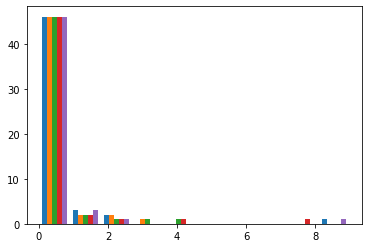

In [115]:
import matplotlib.pyplot as plt

plt.hist(val_y);

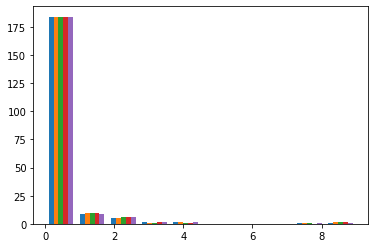

In [116]:
plt.hist(train_y);

In [16]:
gts = np.load('results/gts_val_fold_0.npy')
mean_preds = np.load('results/mean_preds_val_fold_0.npy')
masks = np.load('results/masks_val_fold_0.npy')